In [1]:
# https://www.kaggle.com/code/maddy345/time-forecasting-lstm
import numpy as np
import pandas as pd
import tensorflow
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.metrics import Accuracy
from keras._tf_keras.keras import metrics

In [2]:
df = pd.read_csv('../resources/seattle-weather.csv')
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [3]:
df = df.iloc[:,1:5]
df.head()

,precipitation,temp_max,temp_min,wind
0,0.0,12.8,5.0,4.7
1,10.9,10.6,2.8,4.5
2,0.8,11.7,7.2,2.3
3,20.3,12.2,5.6,4.7
4,1.3,8.9,2.8,6.1


<Axes: >

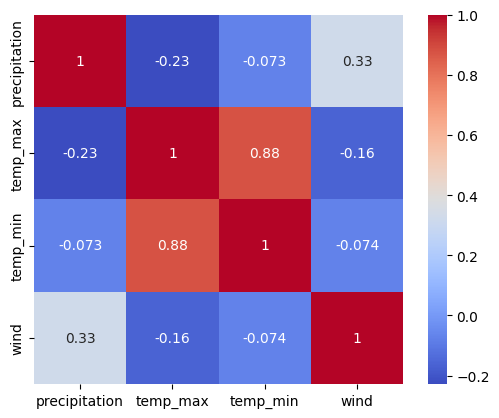

In [4]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)

In [5]:
df.isnull().sum()

precipitation    0
temp_max         0
temp_min         0
wind             0
dtype: int64

In [6]:
df.duplicated().sum()

12

In [7]:
df.drop_duplicates()

,precipitation,temp_max,temp_min,wind
0,0.0,12.8,5.0,4.7
1,10.9,10.6,2.8,4.5
2,0.8,11.7,7.2,2.3
3,20.3,12.2,5.6,4.7
4,1.3,8.9,2.8,6.1
...,...,...,...,...
1456,8.6,4.4,1.7,2.9
1457,1.5,5.0,1.7,1.3
1458,0.0,7.2,0.6,2.6
1459,0.0,5.6,-1.0,3.4


In [8]:
from scipy import stats

t_statistic, p_value = stats.ttest_ind(df['precipitation'], df['wind'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -1.184218948731421
P-value: 0.23642278786502824


In [9]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


Text(0.5, 1.0, 'wind')

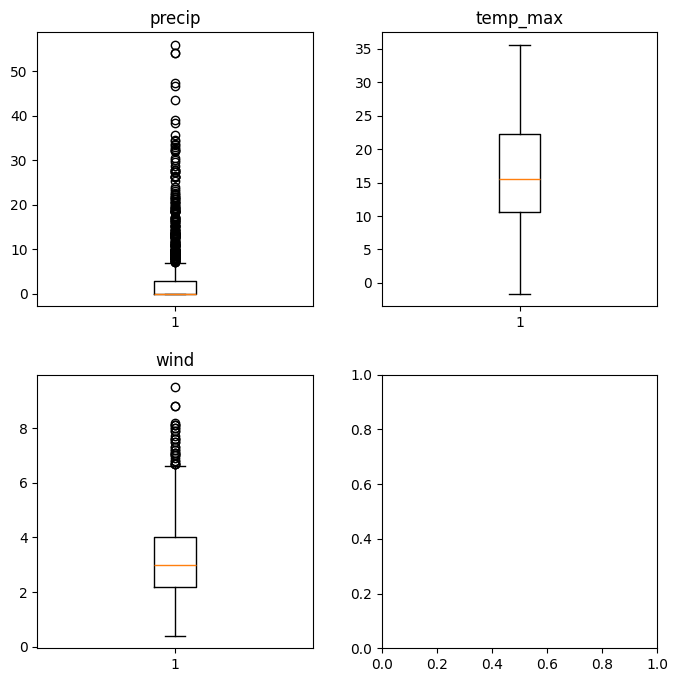

In [10]:
fig, ax = plt.subplots(2,2, figsize = (8,8))
fig.subplots_adjust(wspace = 0.25, hspace = 0.25)

ax[0][0].boxplot(df['precipitation'])
ax[0][0].set_title('precip')

ax[0][1].boxplot(df['temp_max'])
ax[0][1].set_title('temp_max')

ax[1][0].boxplot(df['wind'])
ax[1][0].set_title('wind')

In [11]:
for i in df.columns:
    dt = np.array(df[i])
    Q1 = np.percentile(dt,25)
    Q3 = np.percentile(dt,75)
    IQ = Q3-Q1
    upper = Q3+1.5*IQ
    lower = Q1-1.5*IQ

    dt[(dt[:]>upper) | (dt[:]<lower)]=np.nan
    df[i] = dt

In [12]:
df.isna().sum()

precipitation    206
temp_max           0
temp_min           0
wind              34
dtype: int64

In [13]:
df.shape

(1461, 4)

In [14]:
df = df.interpolate(method = 'linear', axis = 0)
df.isna().sum()

precipitation    0
temp_max         0
temp_min         0
wind             0
dtype: int64

Text(0.5, 1.0, 'wind')

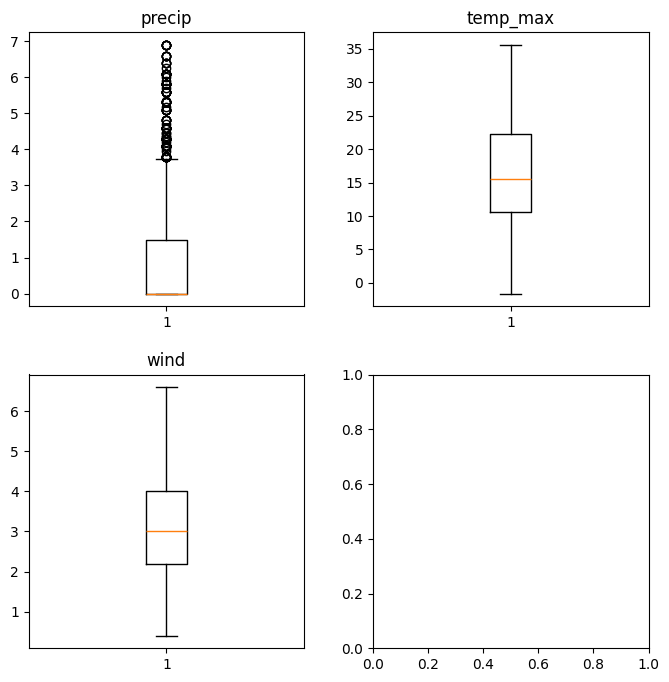

In [15]:
fig, ax = plt.subplots(2,2, figsize = (8,8))
fig.subplots_adjust(wspace = 0.25, hspace = 0.25)

ax[0][0].boxplot(df['precipitation'])
ax[0][0].set_title('precip')

ax[0][1].boxplot(df['temp_max'])
ax[0][1].set_title('temp_max')

ax[1][0].boxplot(df['wind'])
ax[1][0].set_title('wind')

Text(0.5, 1.0, 'Weather Data')

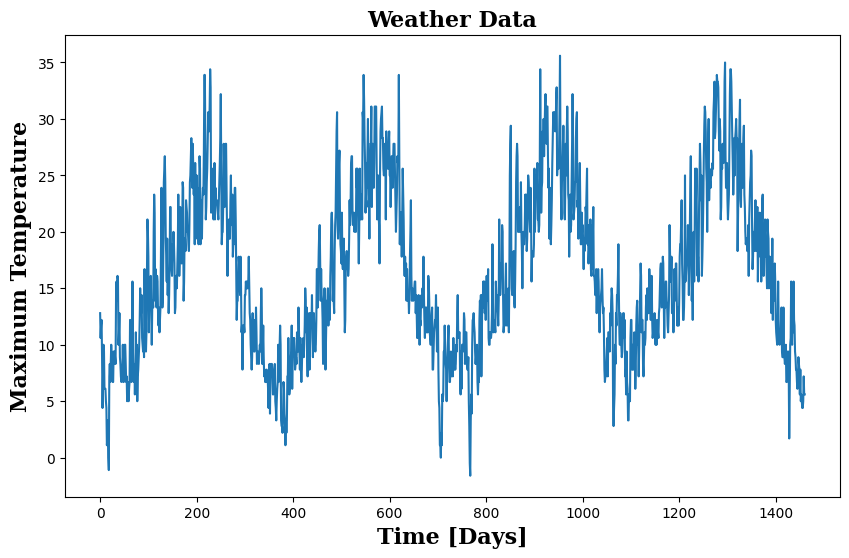

In [16]:
plt.figure(figsize=(10,6))
plt.plot(df['temp_max'])

plt.xlabel('Time [Days]', fontsize=16, fontweight='bold', fontfamily='serif')
plt.ylabel('Maximum Temperature', fontsize=16, fontweight='bold', fontfamily='serif')
plt.title('Weather Data', fontsize=16, fontweight='bold', fontfamily='serif')

In [17]:
df_arr = np.array(df)
df_arr

array([[ 0. , 12.8,  5. ,  4.7],
       [ 0.4, 10.6,  2.8,  4.5],
       [ 0.8, 11.7,  7.2,  2.3],
       ...,
       [ 0. ,  7.2,  0.6,  2.6],
       [ 0. ,  5.6, -1. ,  3.4],
       [ 0. ,  5.6, -2.1,  3.5]])

In [18]:
def create_dataset(data, window):
    X,Y = [],[]
    for i in range(len(data) - window - 1):
        X.append(data[i:i+window,0:data.shape[1]])
        Y.append(data[i+window, 0:data.shape[1]])

    return (np.array(X), np.array(Y))

In [19]:
WINDOW = 50
X,y = create_dataset(df_arr,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
y_test = y[1000:]

1410 1410


In [20]:
print(X_train.shape)
print(y_train.shape)
print(df_arr.shape)

(800, 50, 4)
(800, 4)
(1461, 4)


In [21]:
from keras._tf_keras.keras.layers import Dense, LSTM, Dropout
from keras import Sequential

In [22]:
lstm_model = Sequential()

In [23]:
lstm_model.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50, return_sequences = True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50, return_sequences = True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(4, 'linear'))

c:\Users\slendeverb\Documents\code_code\test\testPython\test\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,804 (280.48 KB)

 Trainable params: 71,804 (280.48 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
lstm_model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics=['accuracy', metrics.Precision()])

In [26]:
history = lstm_model.fit(X_train, y_train,validation_data = (X_val,y_val), epochs=100)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8909 - loss: 84.4128 - precision: 0.9179 - val_accuracy: 1.0000 - val_loss: 98.1066 - val_precision: 0.9983
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9818 - loss: 47.7978 - precision: 0.9114 - val_accuracy: 1.0000 - val_loss: 68.8978 - val_precision: 0.8200
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9849 - loss: 33.5352 - precision: 0.8719 - val_accuracy: 1.0000 - val_loss: 55.5960 - val_precision: 0.8200
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9901 - loss: 28.6068 - precision: 0.8844 - val_accuracy: 1.0000 - val_loss: 46.9206 - val_precision: 0.8200
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9874 - loss: 26.5597 - precision: 0.8674 - val_accuracy: 1.0000 - val_loss: 40.8829 - val_precision: 0.8200
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9839 - loss: 22.6435 - precision: 0.8744 - val_accuracy: 1.0000 

In [27]:
his = pd.DataFrame(history.history)
his.head()

,accuracy,loss,precision,val_accuracy,val_loss,val_precision
0,0.95500,70.689598,0.985302,1.0,98.106583,0.998333
1,0.98375,40.903133,0.888516,1.0,68.897797,0.820000
2,0.98375,31.100039,0.869285,1.0,55.596039,0.820000
3,0.98375,26.431664,0.885012,1.0,46.920624,0.820000
4,0.98375,23.595921,0.873850,1.0,40.882877,0.820000


<Axes: title={'center': 'Loss & Val Loss'}>

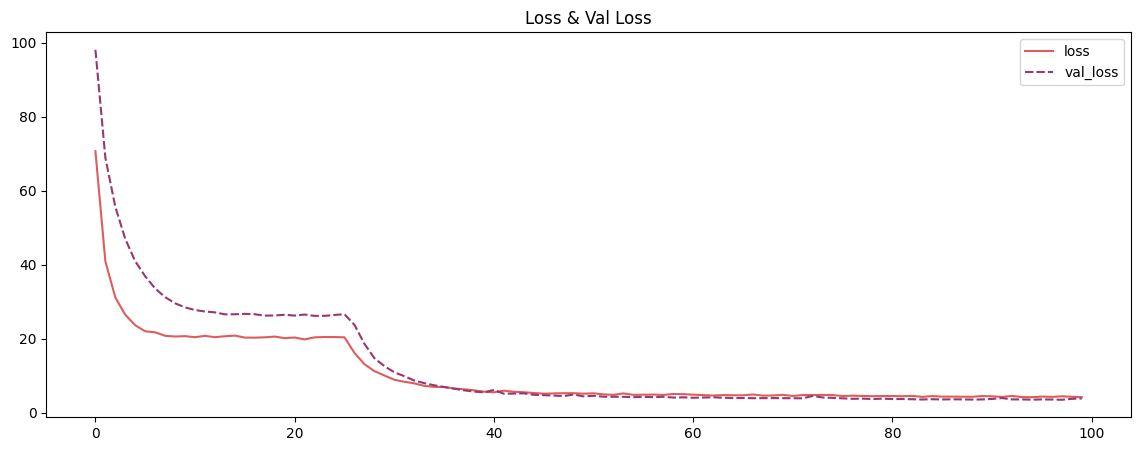

In [35]:
his.columns
history_loss = his[['loss', 'val_loss']]


fig,axes = plt.subplots(1,1,figsize=(14,5))
plt.subplot(1,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare")

In [29]:
train_pred = lstm_model.predict(X_train)
val_pred = lstm_model.predict(X_val)
test_pred = lstm_model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [30]:
pred = np.concatenate([train_pred,val_pred,test_pred])
pred

array([[ 1.1851126,  8.066864 ,  2.487875 ,  3.0841525],
       [ 1.4076965,  9.878283 ,  3.6688657,  3.2241983],
       [ 1.6167178, 11.066524 ,  4.9803004,  3.4494438],
       ...,
       [ 1.3881669,  7.903378 ,  1.8524127,  3.1143599],
       [ 1.6085721,  9.02815  ,  3.1779058,  3.2958684],
       [ 1.556108 ,  8.216369 ,  2.9136903,  3.267198 ]], dtype=float32)

In [31]:
pred_ = pred[:,1]
pred_

array([ 8.066864,  9.878283, 11.066524, ...,  7.903378,  9.02815 ,
        8.216369], dtype=float32)

<Axes: title={'center': 'Test Results'}>

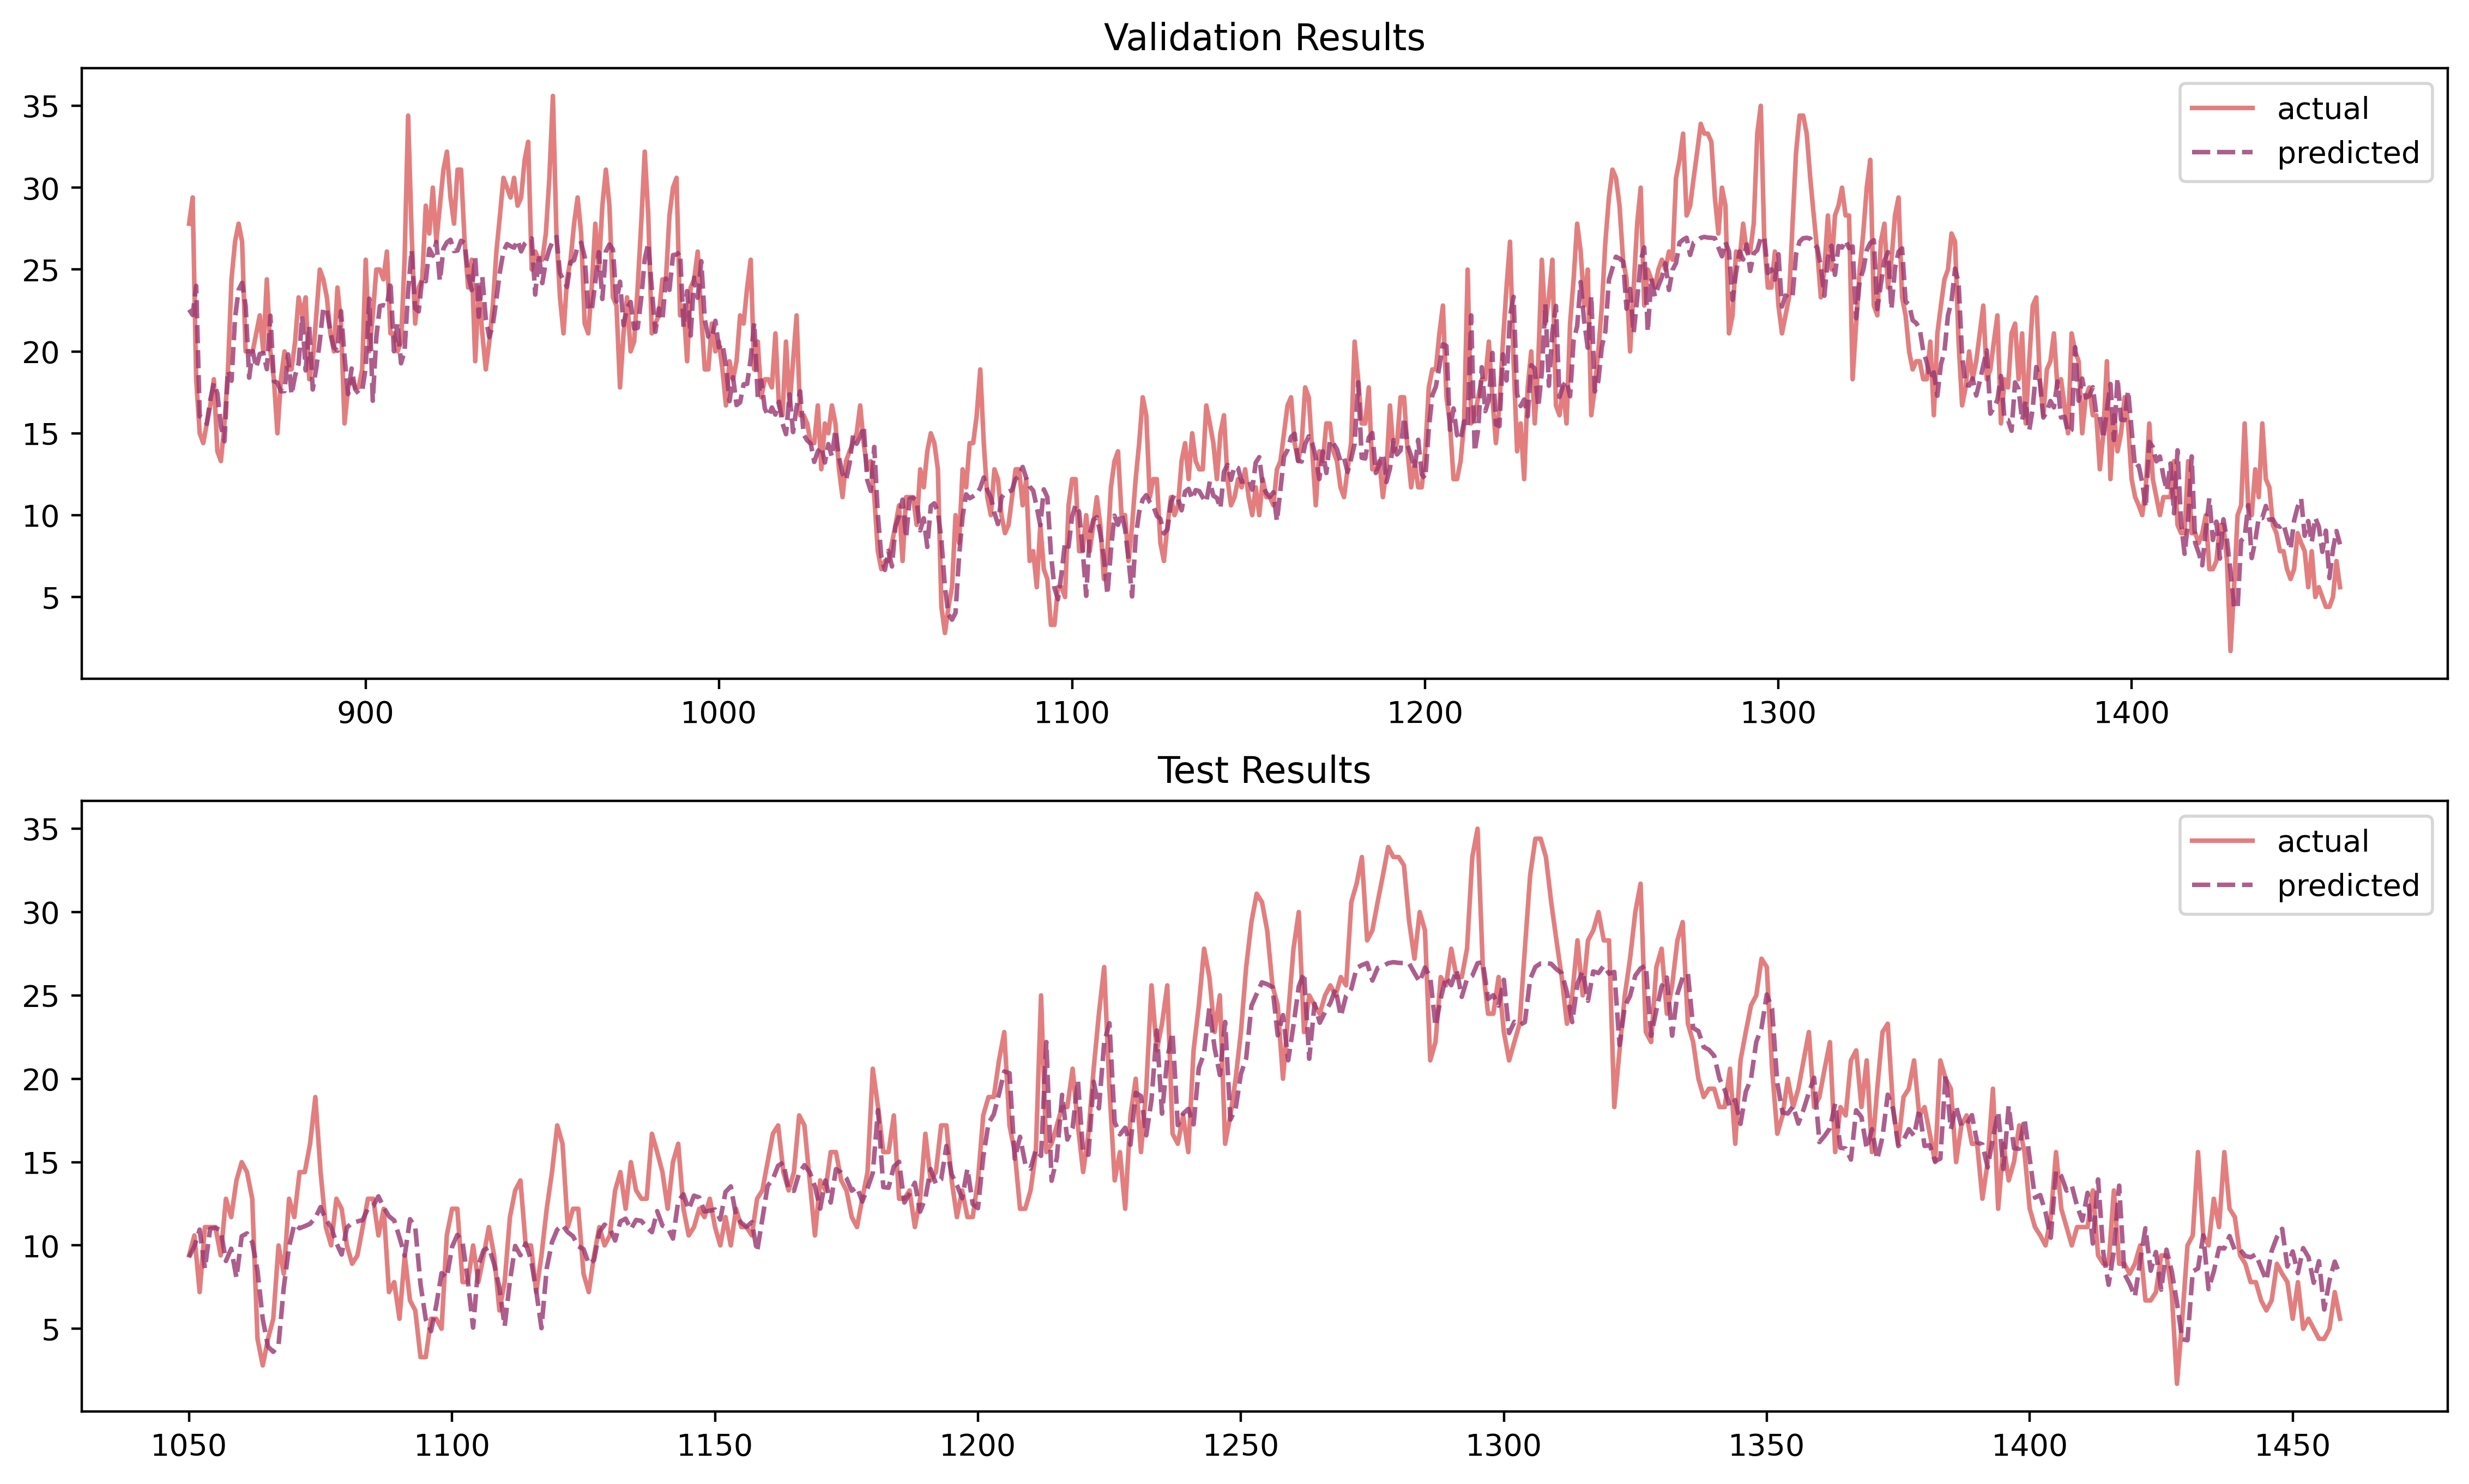

In [32]:
df_pred = pd.DataFrame(df['temp_max'].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:1460]
df_pred["predicted"] = pred_

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None)

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None)

<Axes: title={'center': 'Test Results'}>

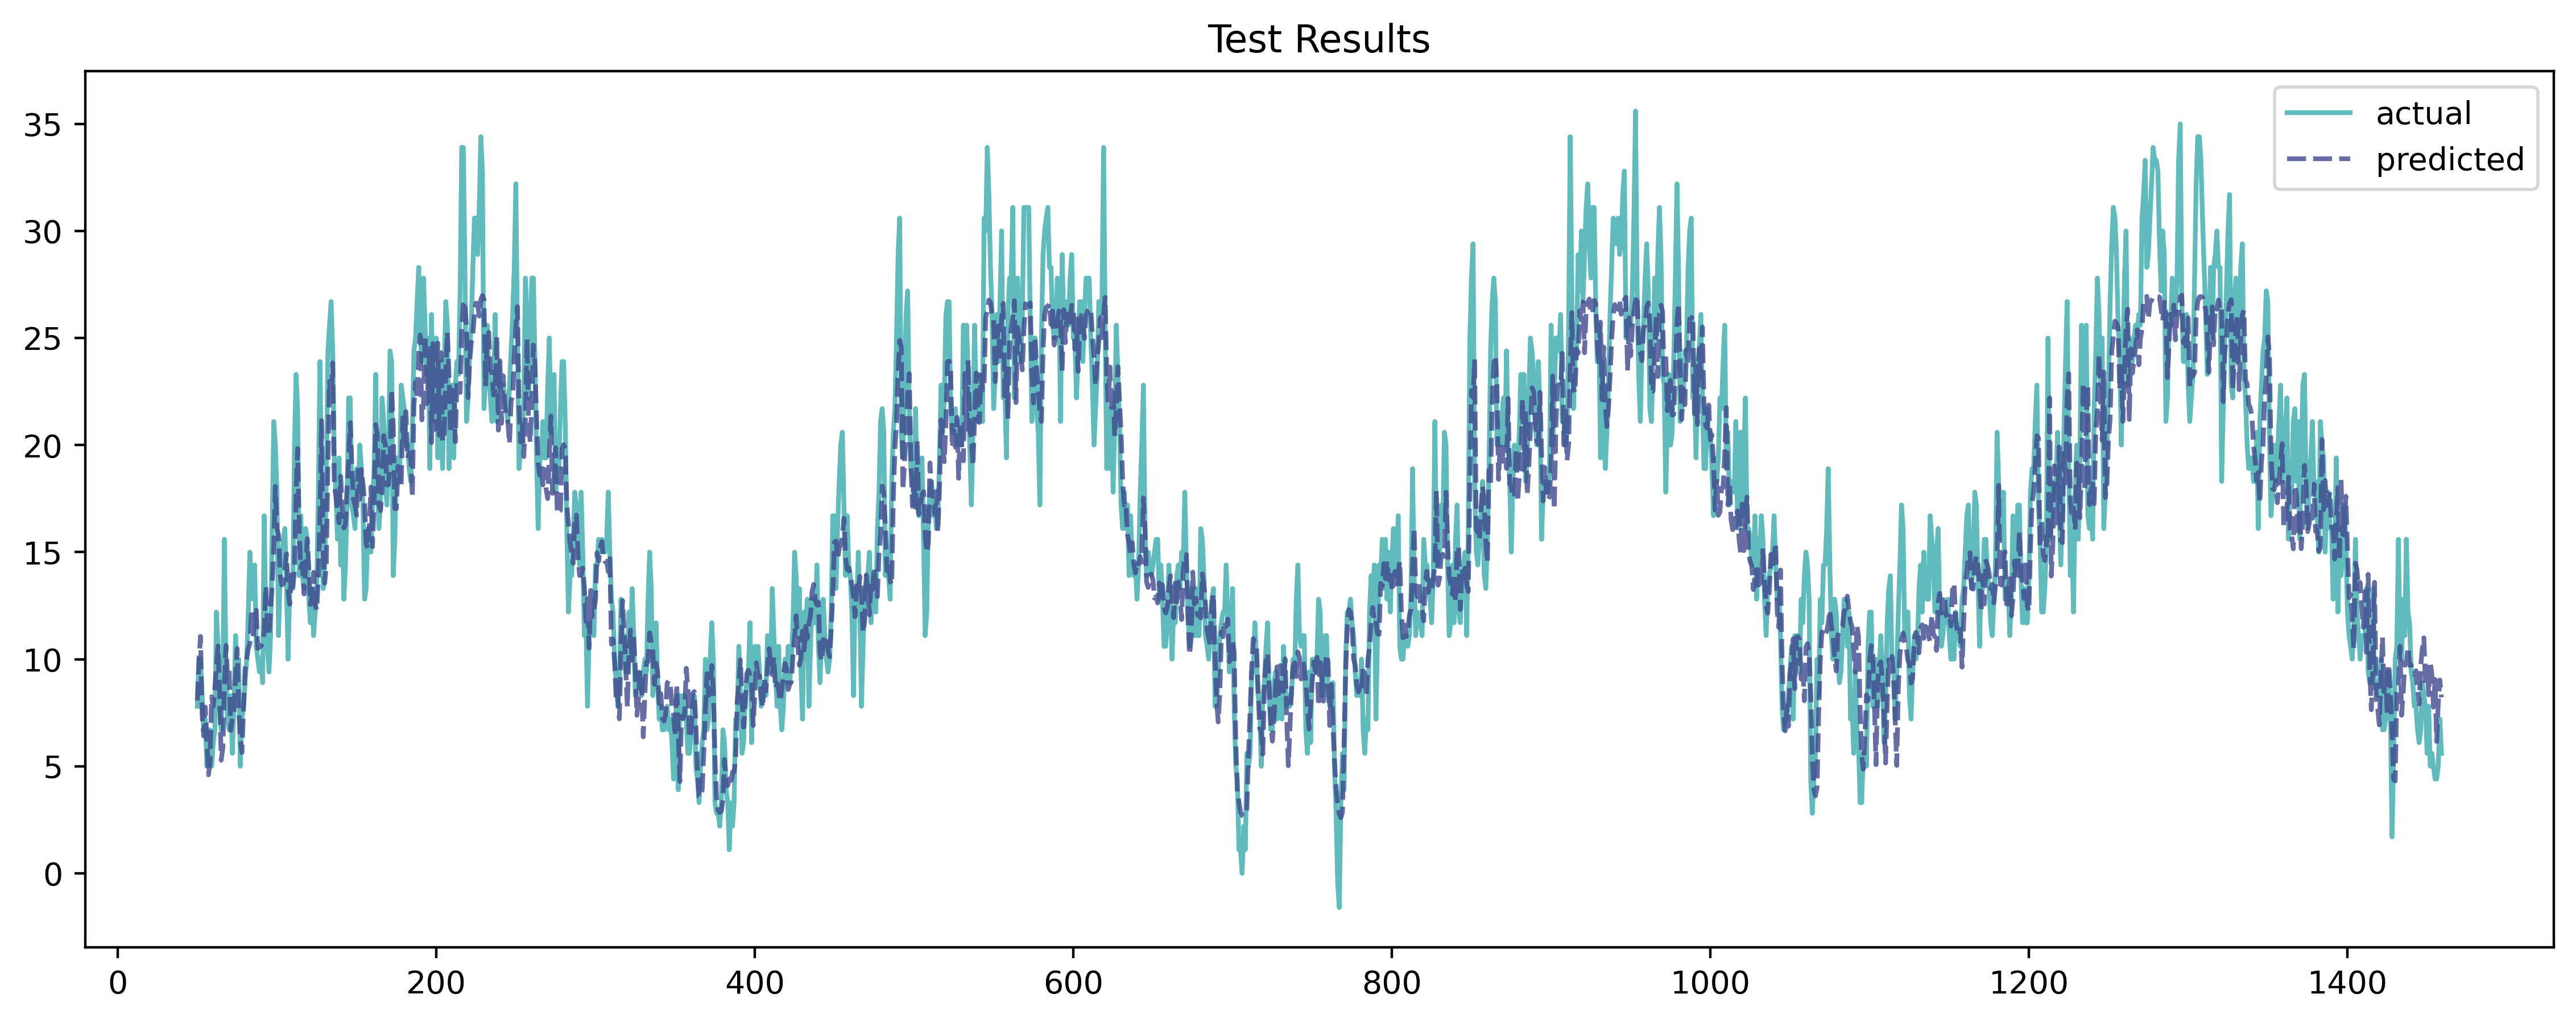

In [36]:
fig,axes = plt.subplots(1,1,figsize=(14,5),dpi=400)

plt.subplot(1,1,1)
plt.title("Test Results")
sns.lineplot(df_pred[:],alpha=0.8,palette = 'mako_r',linestyle=None)